In [1]:
from IPython.display import Image

### 지난주 내용 수정

------

### HDFSUtils



In [ ]:
object HDFSUtils {

  /**
   * Delete Directory on HDFS....
   */
  import org.apache.spark.SparkContext
  import org.apache.hadoop.conf.Configuration
  import org.apache.hadoop.fs.Path

  val hdfsPath = "hdfs://hadoop-master-01:9000"

  def delDirHDFS(path: String, sc: SparkContext) = {
    //--Hadoop Configuration.... sc.hadoopConfiguration => A default Hadoop Configuration for the Hadoop code (e.g. file systems) that we reuse....
    val hadoop_conf = new Configuration(sc.hadoopConfiguration)
    val hdfsFS = new Path(hdfsPath).getFileSystem(hadoop_conf)
    //--Delete a file.... recursive - if path is a directory and set to true, the directory is deleted else throws an exception.... In case of a file the recursive can be set to either true or false.....
    hdfsFS.delete(new Path(path), true) 
  }
}

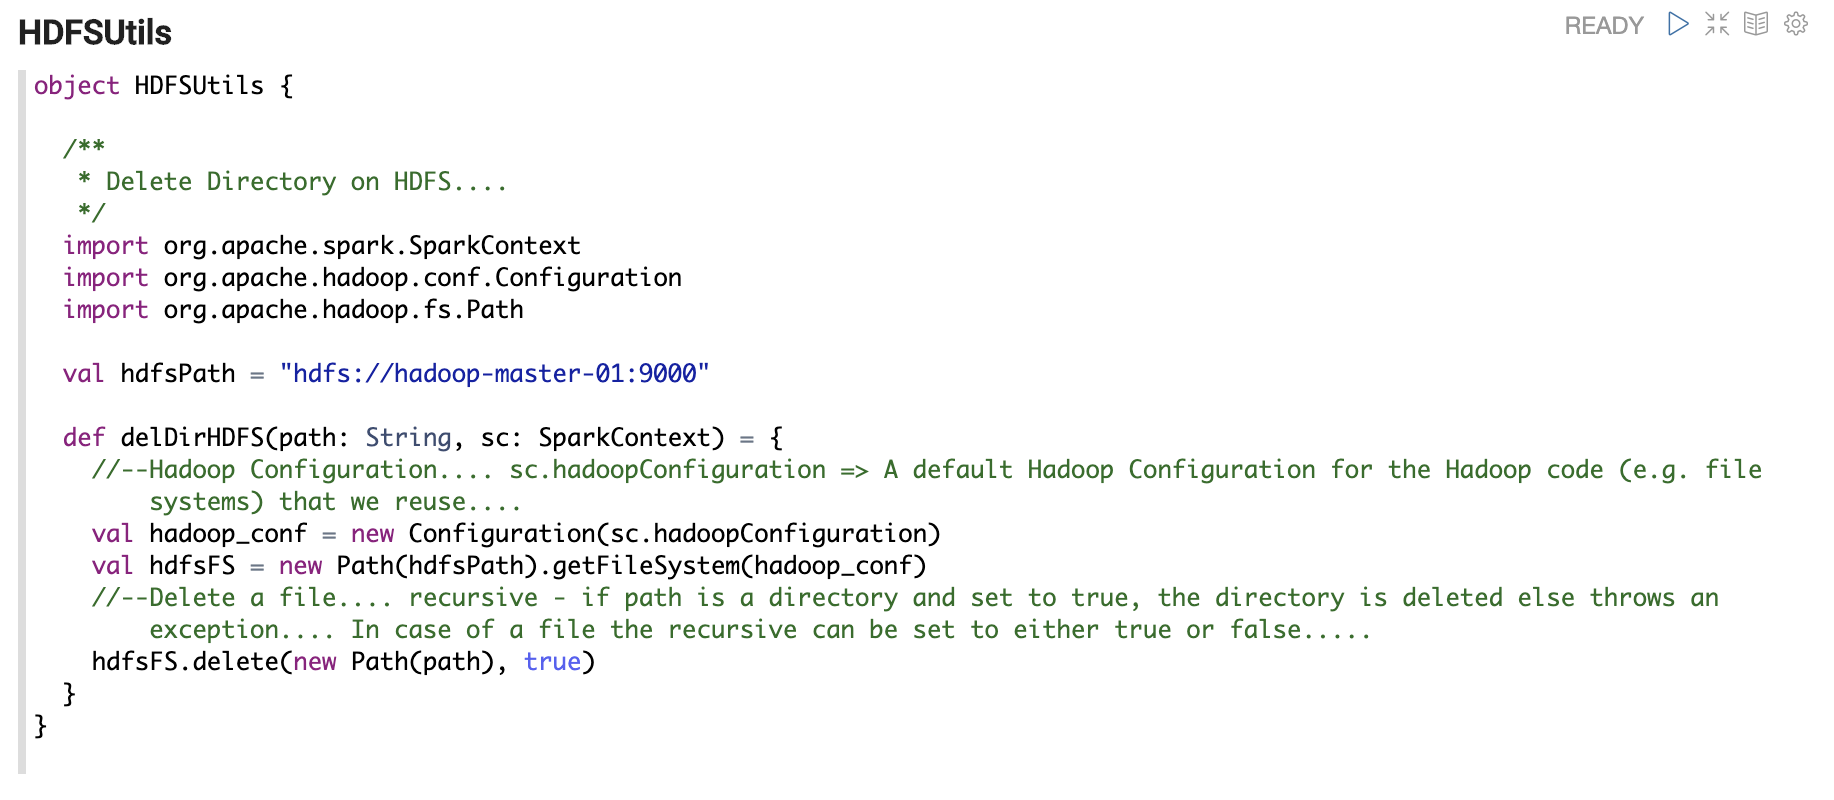

In [2]:
Image('./capture/stream_01.png')

### Train에 내용 추가

- 모델 저장 전 대상 HDFS Directory 삭제....

    HDFSUtils.delDirHDFS(outputModelDir, sc)
    HDFSUtils.delDirHDFS(outputModelDir + "_save", sc)
    

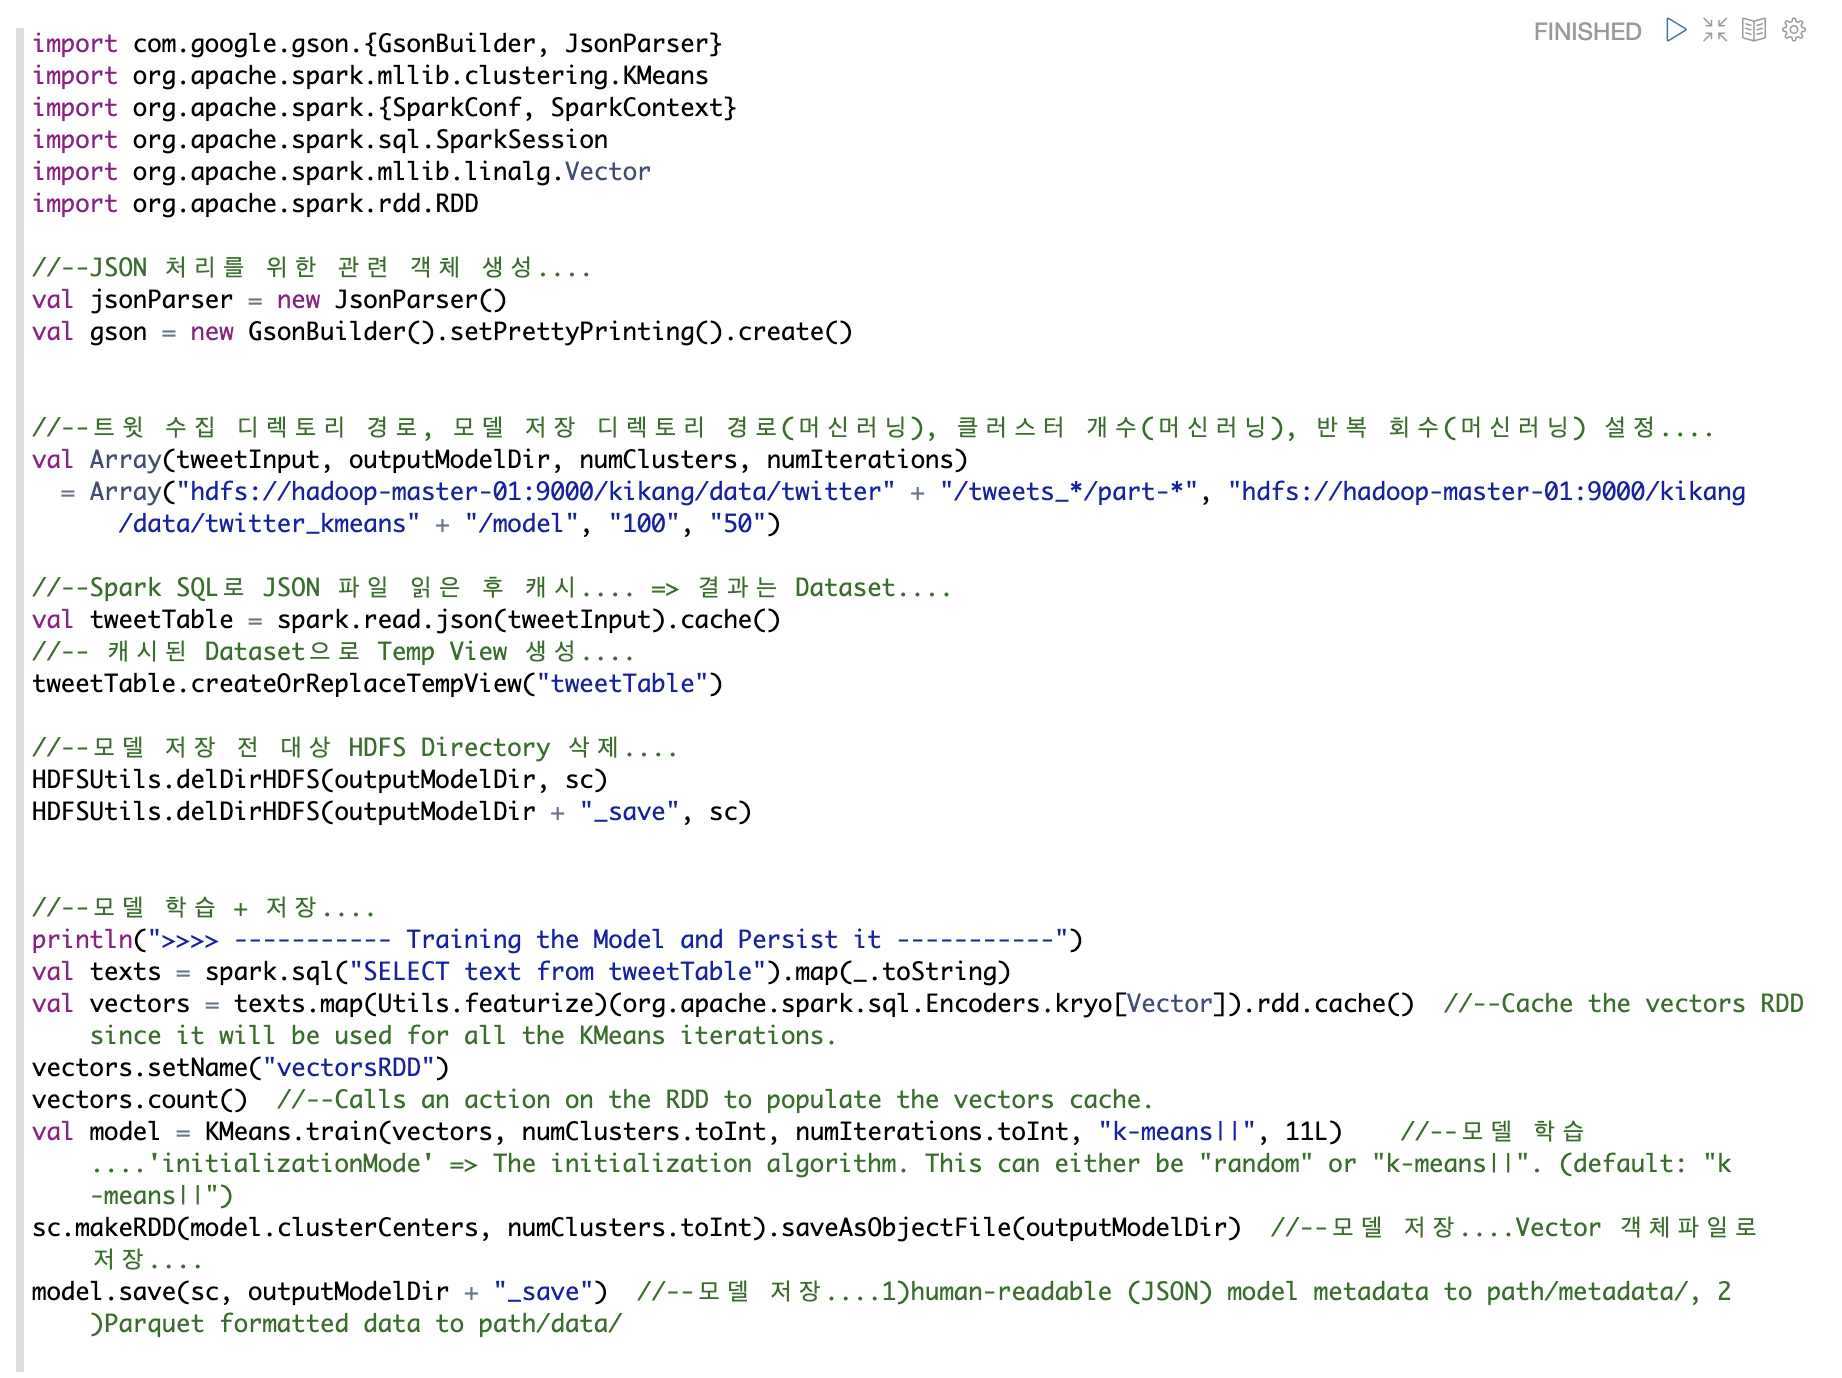

In [3]:
Image('./capture/stream_02.png')

-----

- saveAsObjectFile : Object File로 저장 가능 
- model.save == meta data로 저장됨 :: 이런 식으로 저장하면 된다.


### utils


In [ ]:
object Utils extends Serializable {

    import org.apache.spark.mllib.linalg.Vector
    import org.apache.spark.mllib.feature.HashingTF
    import twitter4j.auth.OAuthAuthorization
    import twitter4j.conf.ConfigurationBuilder

 def getAuth = {   
    //--트위터 계정 + 트위터 App (with Consumer Key and Access Token) 필요....
    val Array(consumerKey, consumerSecret, accessToken, accessTokenSecret) = Array("edgWhFgM9GML1TfA7hvzALTE9", "Jssdq2Kt1RDR3P0hG0GvpFvtjMg0JkG7LMR8qsq3ZhW8Wv9OVS", "168871039-RZ0pUTk1Ixzju4Dv0hmr6w1b0Mt7shlvHLnClqaO", "cICFbap5aoOQW2WB7Jpd0HwKL1viFv5BCg9pM8UMbWTkB")

    val builder: ConfigurationBuilder = new ConfigurationBuilder()
    builder.setOAuthConsumerKey(consumerKey);
    builder.setOAuthConsumerSecret(consumerSecret);
    builder.setOAuthAccessToken(accessToken);
    builder.setOAuthAccessTokenSecret(accessTokenSecret);
    Some(new OAuthAuthorization(builder.build()))
  }

  /**
   * Create feature vectors by turning each tweet into bigrams of characters (an n-gram model)
   * and then hashing those to a length-1000 feature vector that we can pass to MLlib.
   * This is a common way to decrease the number of features in a model while still
   * getting excellent accuracy (otherwise every pair of Unicode characters would
   * potentially be a feature).
   */
//   val numFeatures = 1000
//   val tf = new HashingTF(numFeatures)

  def featurize(s: String): Vector = {
    // tf.transform(s.sliding(2).toSeq)  //--transform()....Transforms the input document into a sparse term frequency vector.
    val numFeatures = 1000
    new HashingTF(numFeatures).transform(s.sliding(2).toSeq)
  }
}

-----

### Predict


In [ ]:
import org.apache.spark.SparkConf
import org.apache.spark.mllib.clustering.KMeansModel
import org.apache.spark.mllib.linalg.Vector
import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter.TwitterUtils

//--모델 저장 디렉토리 경로(머신러닝), 필터링 대상 클러스터 번호(머신러닝) 설정....
val Array(modelFile, clusterNumber) 
  = Array("hdfs://hadoop-master-01:9000/kikang/data/twitter_kmeans" + "/model", "14")  //--(62,65,94,10)

//--스트리밍 컨텍스트 생성....
println(">>>> Initializing Streaming Spark Context....")
val ssc = new StreamingContext(sc, Seconds(5))

//--트위터 스트림 생성....
println(">>>> Initializing Twitter stream....")
val tweets = TwitterUtils.createStream(ssc, Utils.getAuth)
//val tweetsText = tweets.map(_.getText)
val tweetsText = tweets.map(status => (status.getLang, status.getText))

//--모델 생성....
println(">>>> Initalizaing the the KMeans model....")
val model = new KMeansModel(ssc.sparkContext.objectFile[Vector](modelFile.toString).collect())  //--Vector 객체파일로 저장된 모델 로드....
val model2 = KMeansModel.load(ssc.sparkContext, modelFile.toString + "_save")  //--JSON과 Parquet로 저장된 모델 로드....
println(s""">>>> model2.k : ${model2.k}""")

//--필터링 대상 클러스터 번호로 트윗 텍스트 필터링.... => user.lang의 언어와 text의 언어가 다른 경우에도 클러스터링에 의해 필터링 됨.... ex) (en,RT @naissy_q: كيف تترحمون على مجرم قاتل قتل ودمر وهو الذي ناصر الجرذان الحوثيين لقتل الشعب اليمني الغالي؟ اللهم اضرب الظالم بالظا… ), (en,RT @sawabcenter: توفي الشيخ زايد رحمه الله منذ 13 عاماً لكنه لا يزال العمود الأساسي الذي تقوم عليه دولة #الإمارات.. أبناؤه… )
//-- => user.lang 필드가 없어졌음....
//val filteredTweets = tweetsText.filter(text => model.predict(Utils.featurize(text)) == clusterNumber)
val filteredTweets = tweetsText.filter(lang_text => model.predict(Utils.featurize(lang_text._2)) == clusterNumber)

//--Start the streaming computation....
println(">>>> Initialization complete....")
println(s">>>> clusterNumber : ${clusterNumber}")

#### utils 실행 후 predict 실행
-----

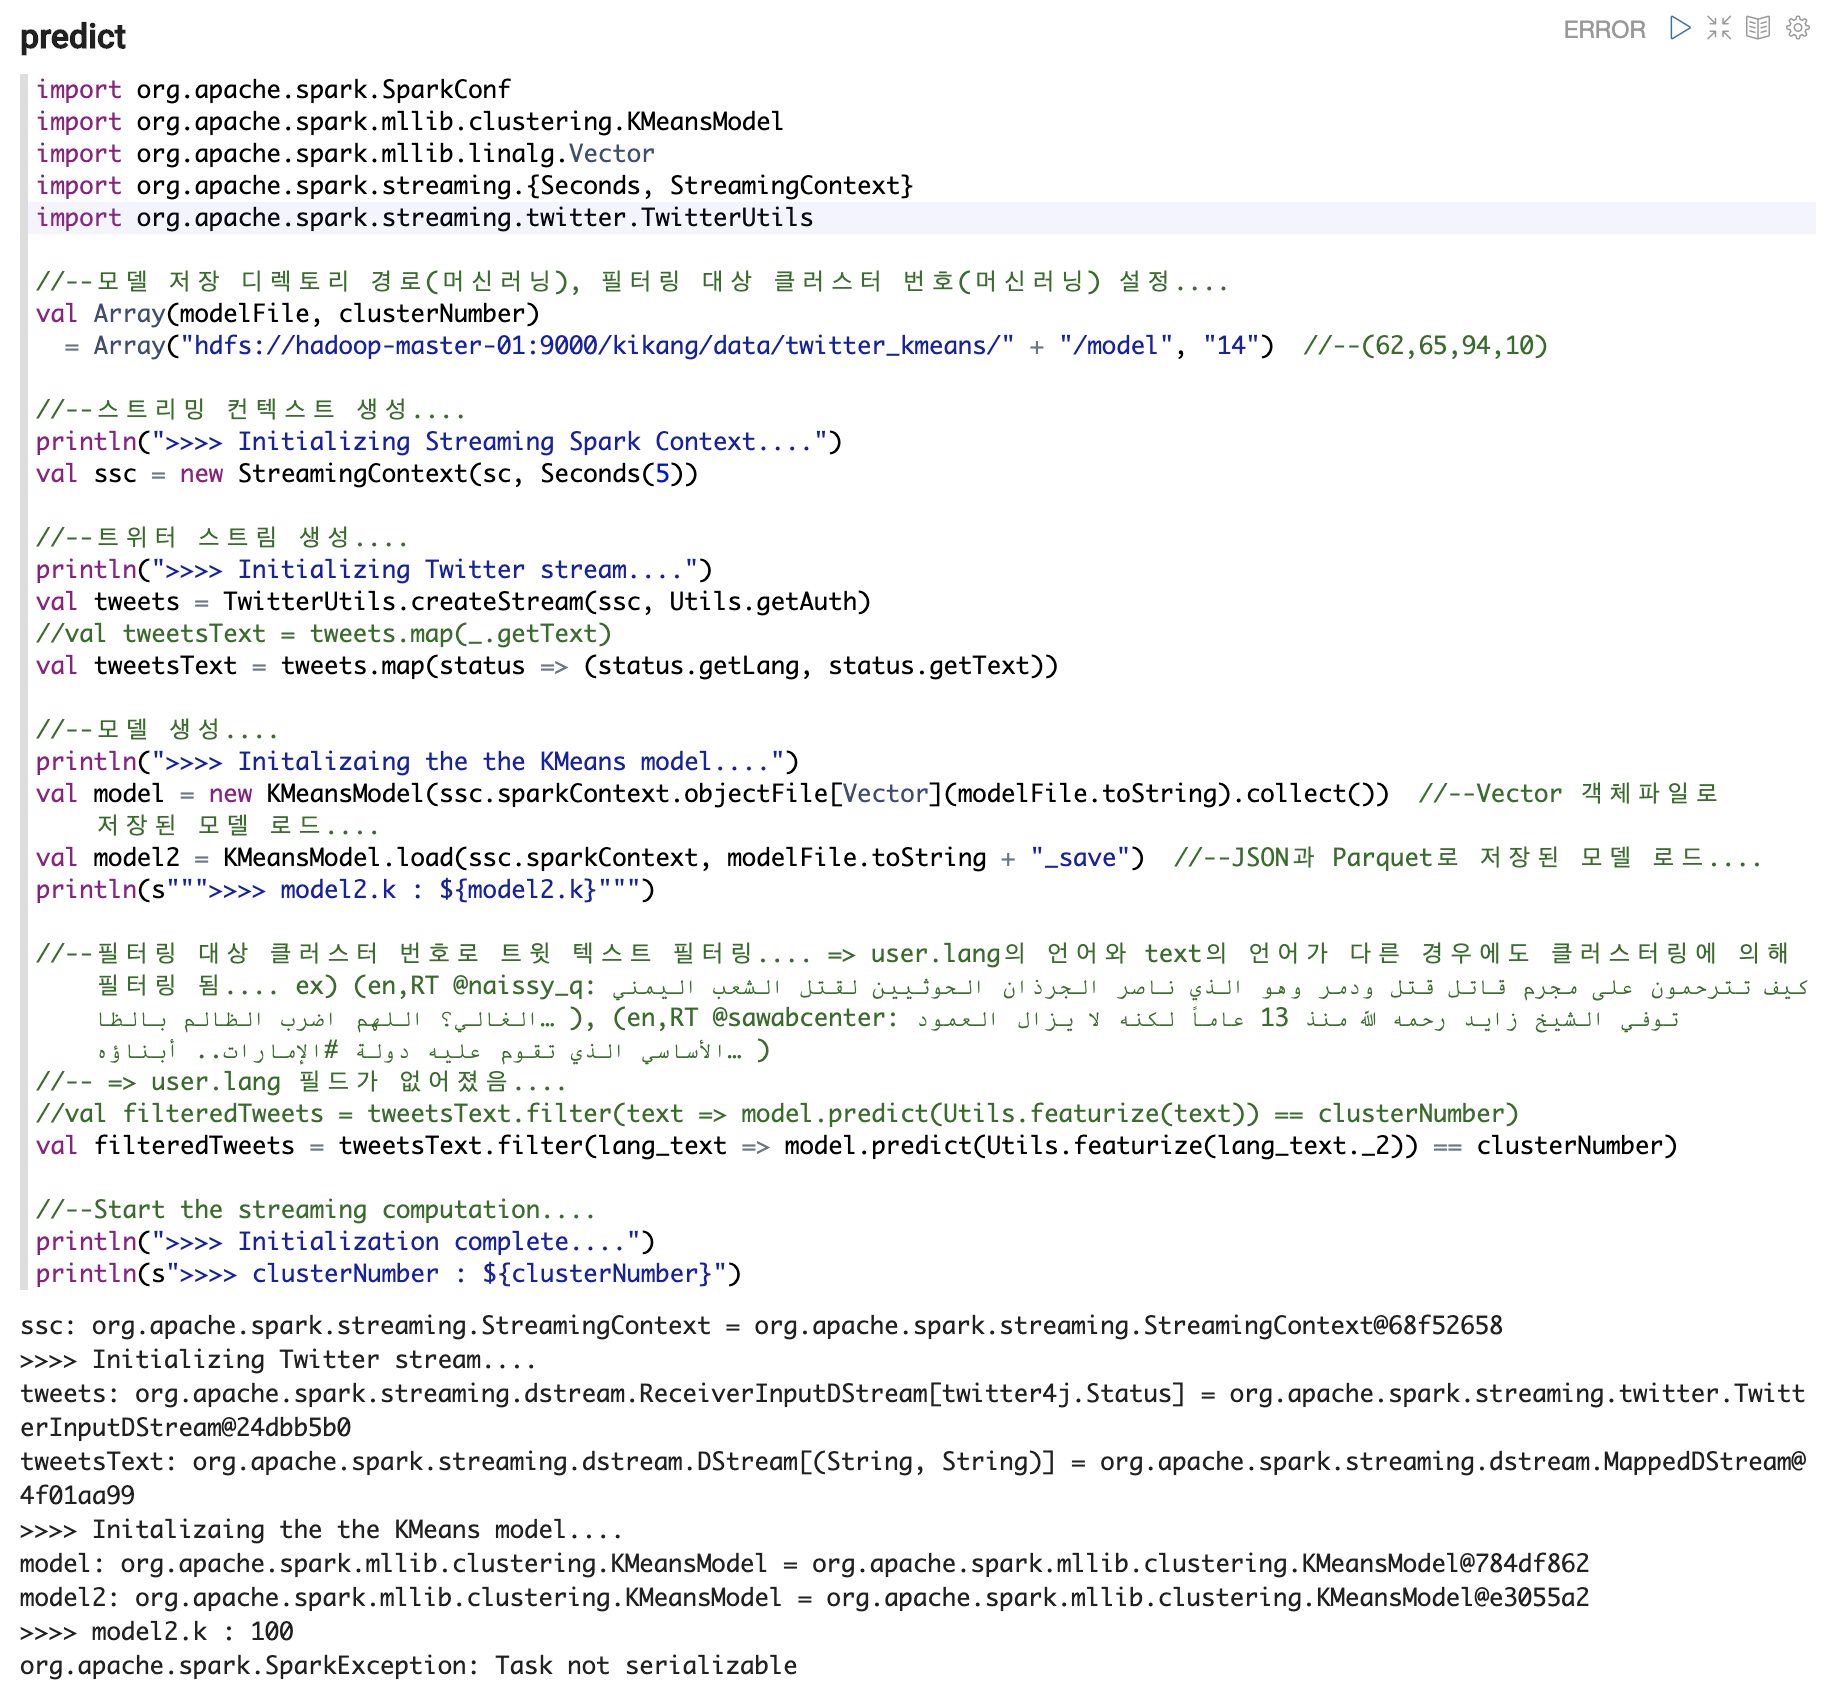

In [4]:
Image('./capture/stream_03.png')

### Avoid Task not serializable


In [ ]:
val tweetsText2 = tweetsText.transform((rdd, time)= > {
    val rdd2=model2.predict(rdd.map(lang_text= > Utils.featurize(lang_text._2)))
    val rdd3=rdd2.zip(rdd) // RDD[(clusterNumber, (lang, text)]
    rdd3.filter(x=> x._1 == clusterNumber.toInt).map(x = > (x._1, x._2._1, x._2._2.replaceAll("\n", " "), time.milliseconds))
})

// DStream[(clusterNumber, lang, text, timemili)]
tweetsText2.foreachRDD((rdd, time)= > {
    val tweetsFiltered=rdd.toDF("clusterNumber", "lang", "text", "timemili")
    tweetsFiltered.createOrReplaceTempView("tweetsFiltered") // Temp View
    // save Table on DW(data warehouse)
    tweetsFiltered.write.mode("append").saveAsTable("tweetsFilteredDF")
})


-----
 - transform : RDD를 새로운 RDD로 바꿔서 사용
 - foreachRDD : action :: return 이 존재하지 않음 
 - zip (앞에 rdd, 뒤에 rdd)

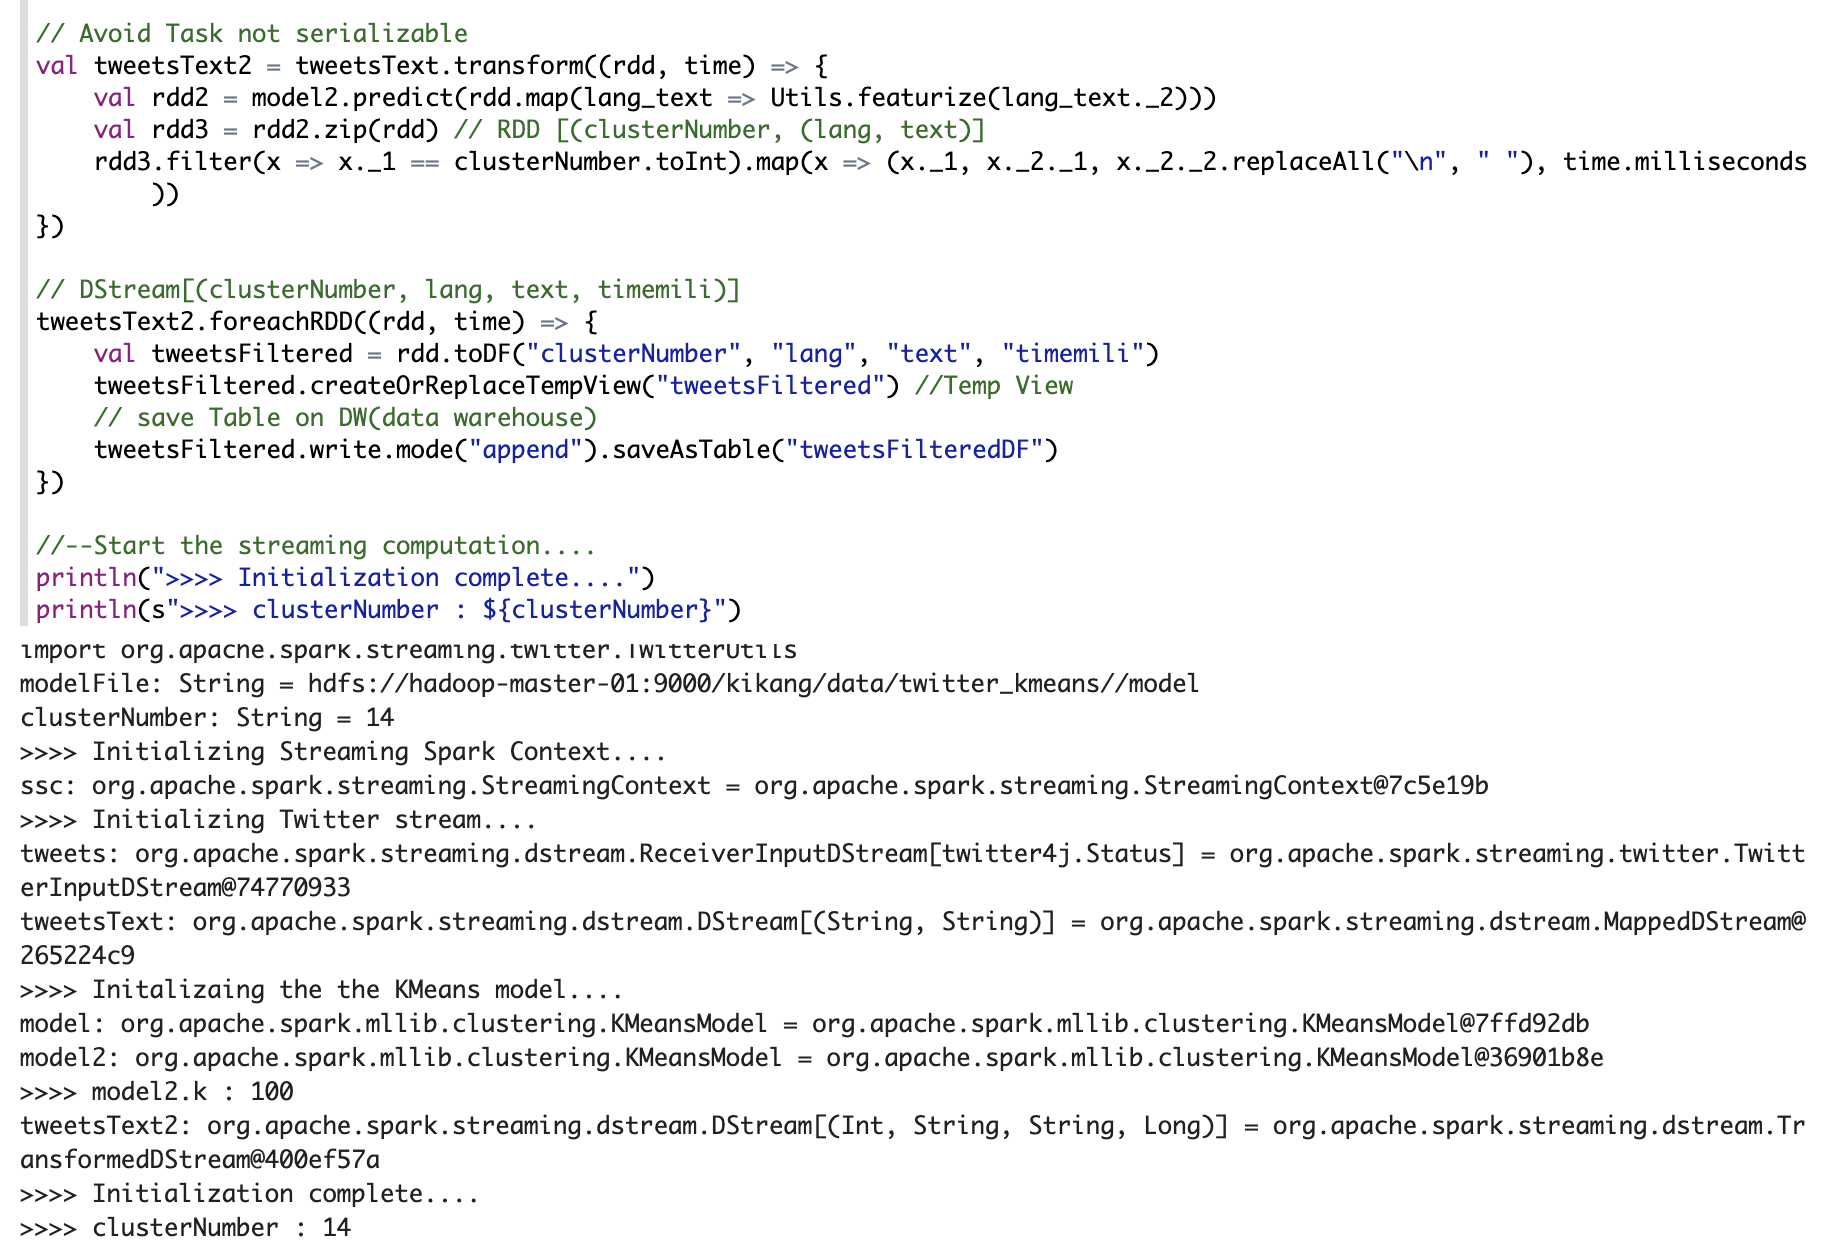

In [9]:
Image('./capture/stream_04.png')

-----
### streaming start
    ssc.start()
    
### streaming state
    ssc.getState

### streaming stop :: stay SparkContext
    ssc.stop(false)

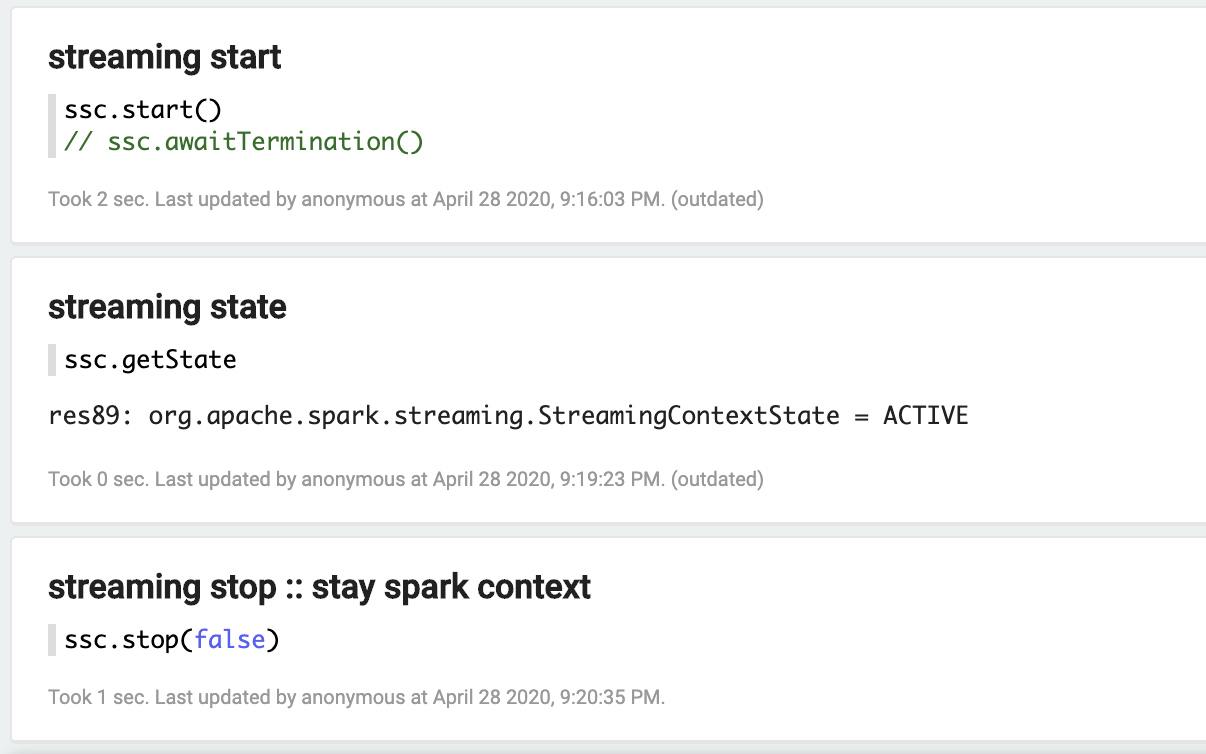

In [10]:
Image('./capture/stream_05.png')

### predict 수정
-----
#### Avoid Task not serializable

In [ ]:
val tweetsText2 = tweetsText.transform((rdd, time) => {
    // val rdd2 = model2.predict(rdd.map(lang_text => Utils.featurize(lang_text._2))) // utils.featurize error
    
    val rdd2 = model2.predict(rdd.map(lang_text => new org.apache.spark.mllib.feature.HashingTF(1000).transform(lang_text._2.sliding(2).toSeq)))
    val rdd3 = rdd2.zip(rdd) // RDD [(clusterNumber, (lang, text)]
    
    // rdd3.filter(x => x._1 == clusterNumber.toInt).map(x => (x._1, x._2._1, x._2._2.replaceAll("\n", " "), time.milliseconds))
    rdd3.filter(x => x._1 == 14).map(x => (x._1, x._2._1, x._2._2.replaceAll("\n", " "), time.milliseconds))
})

-----
  #### utils/Object 따로 생성하는 이유 
  - 자주사용하는 함수는 Object에 담아놓는 것이 좋다. 

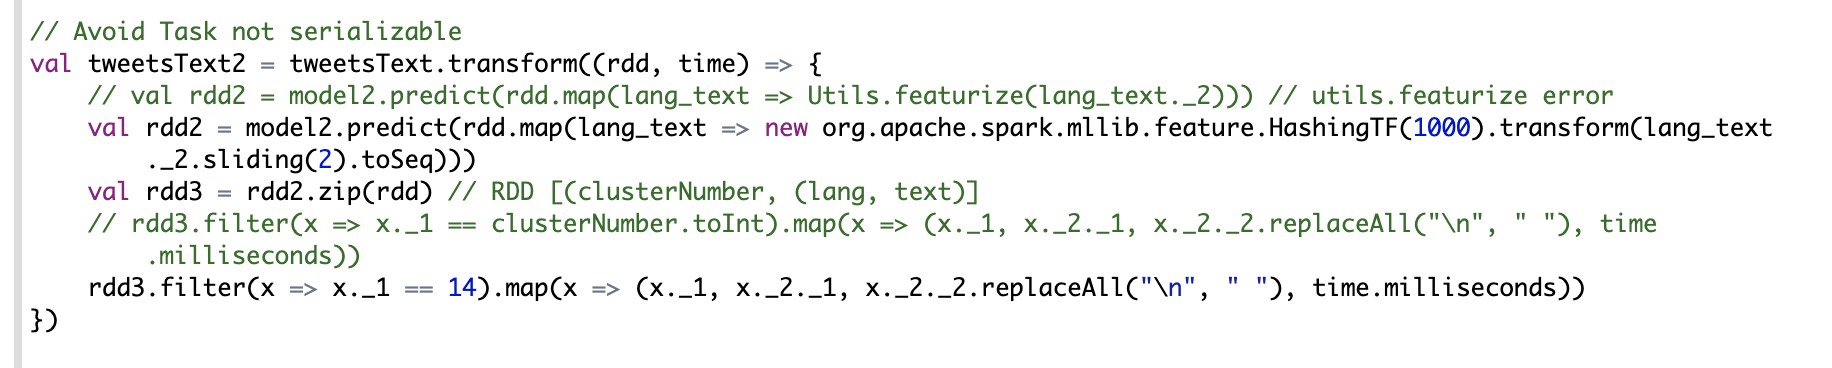

In [13]:
Image('./capture/stream_06.png')

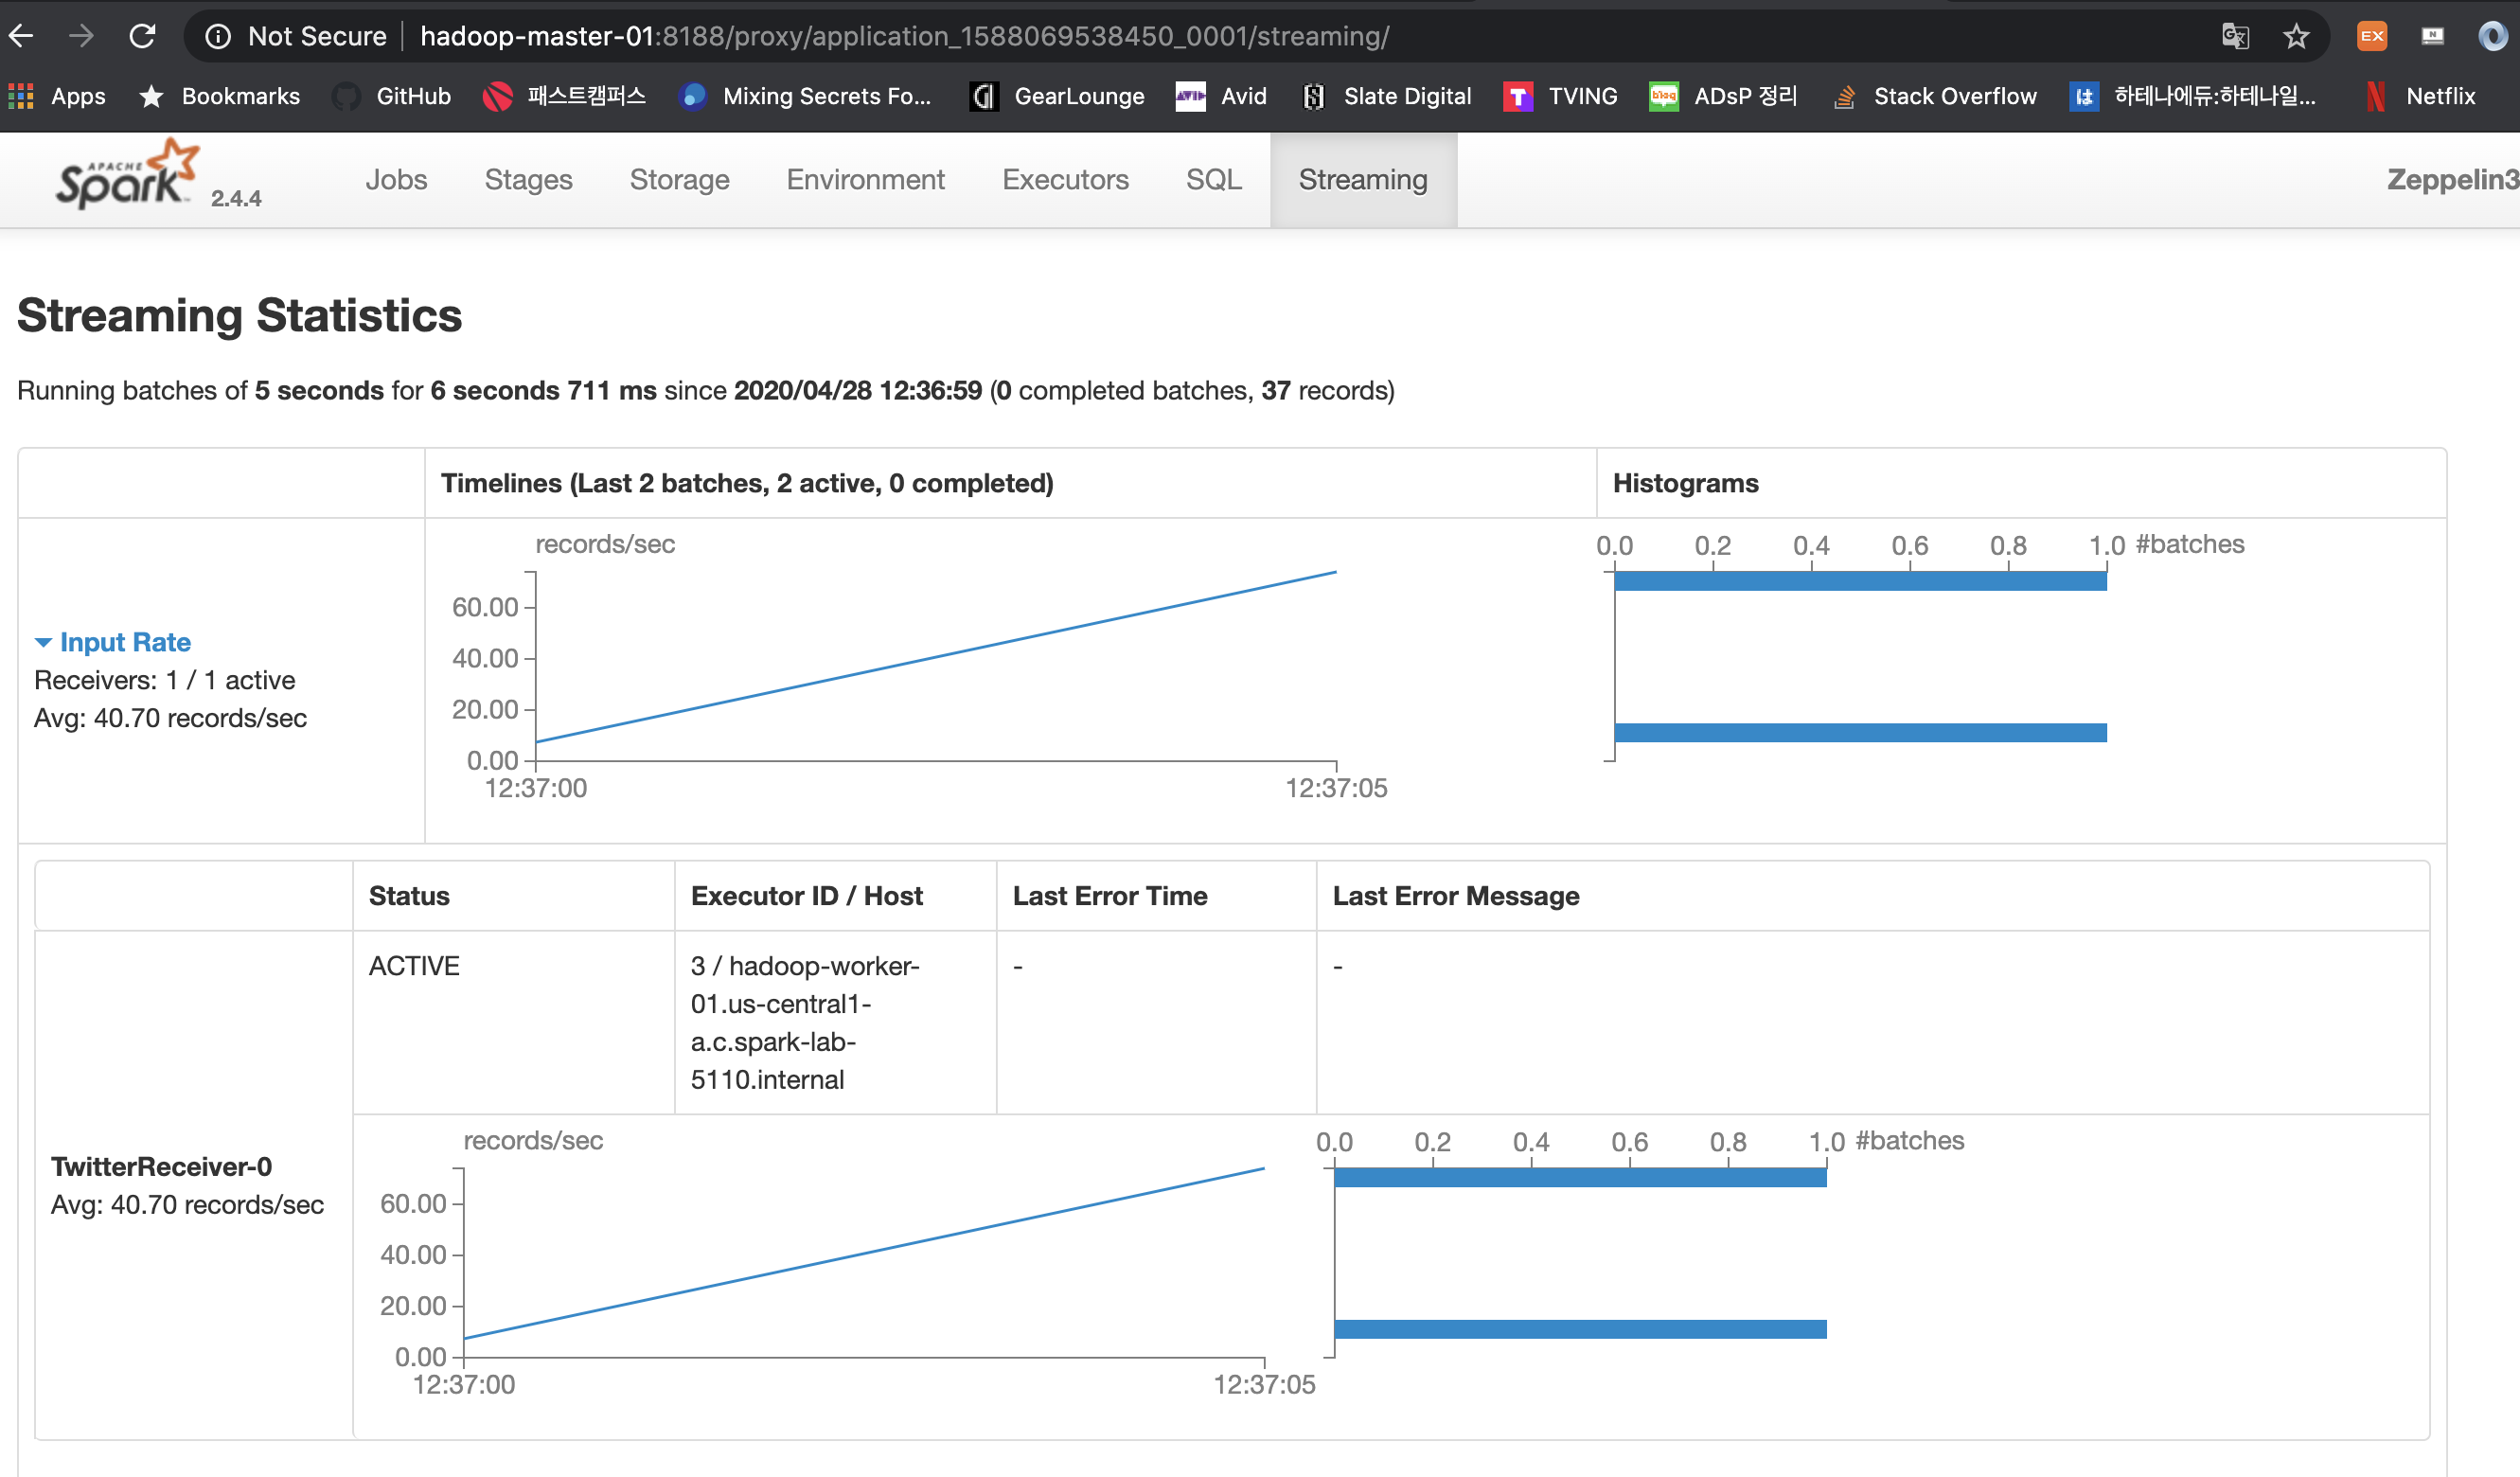

In [12]:
Image('./capture/stream_07.png')

----
### Table list

In [ ]:
%sql

show tables

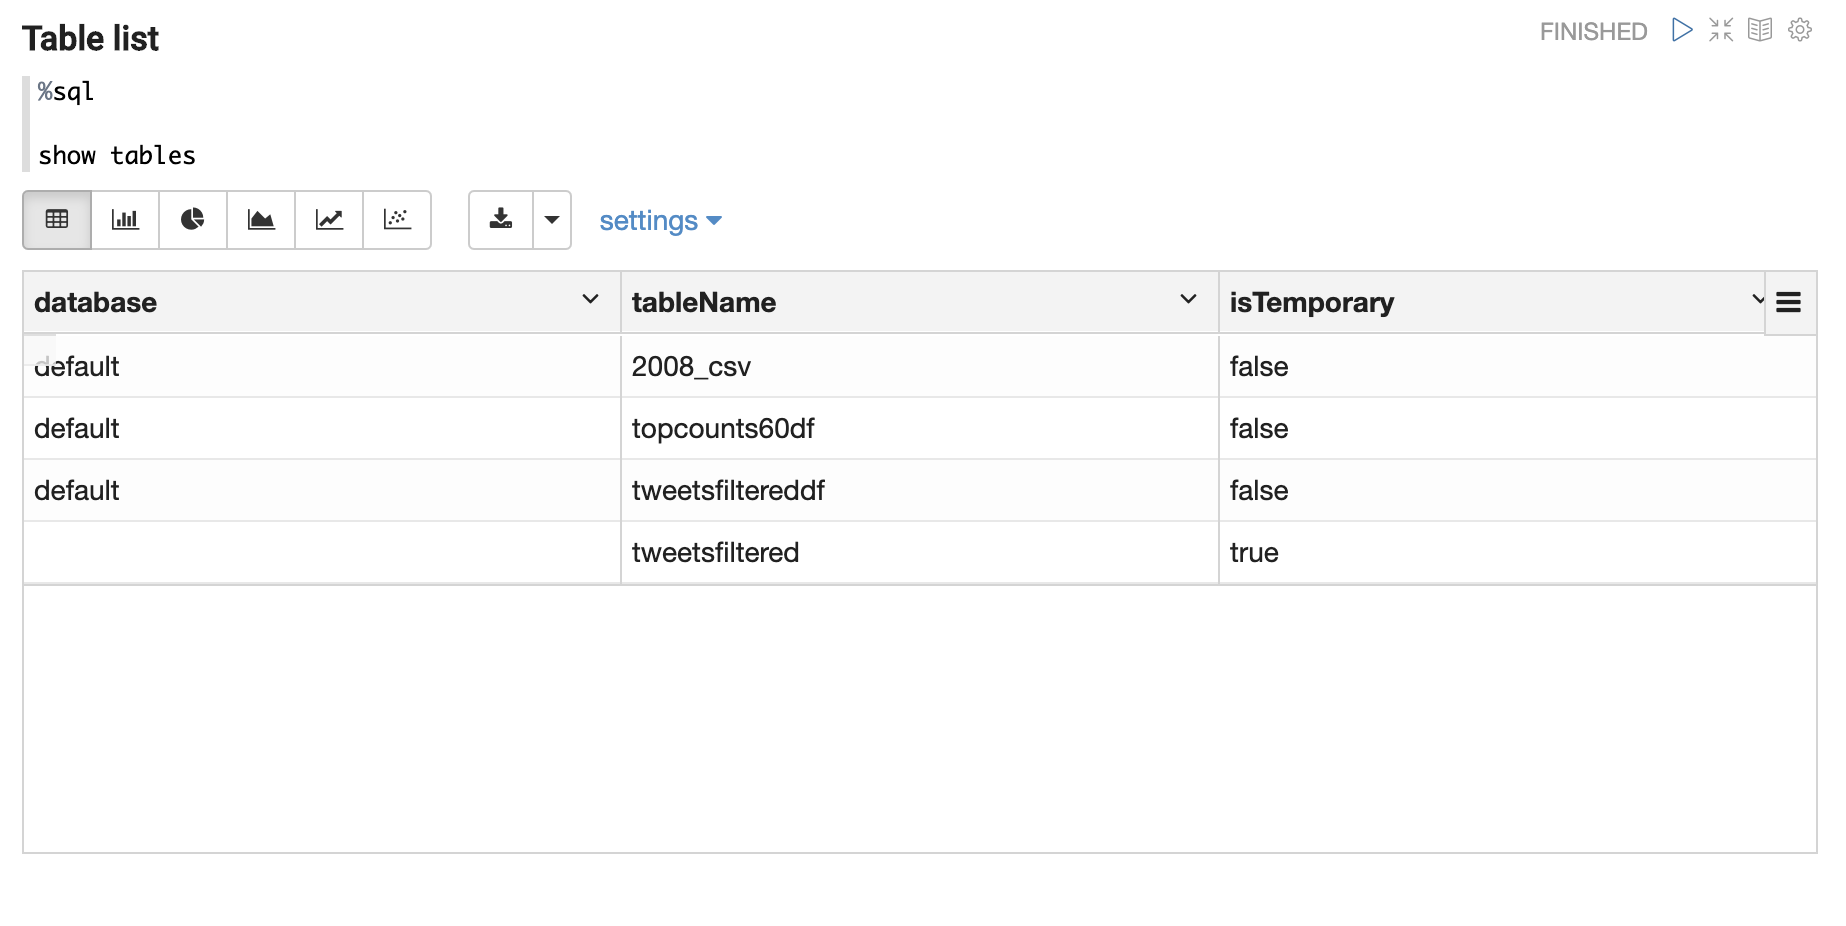

In [14]:
Image('./capture/stream_08.png')

----
#### Temp View search

   

In [ ]:
%sql

Select
*
from
tweetsFiltered

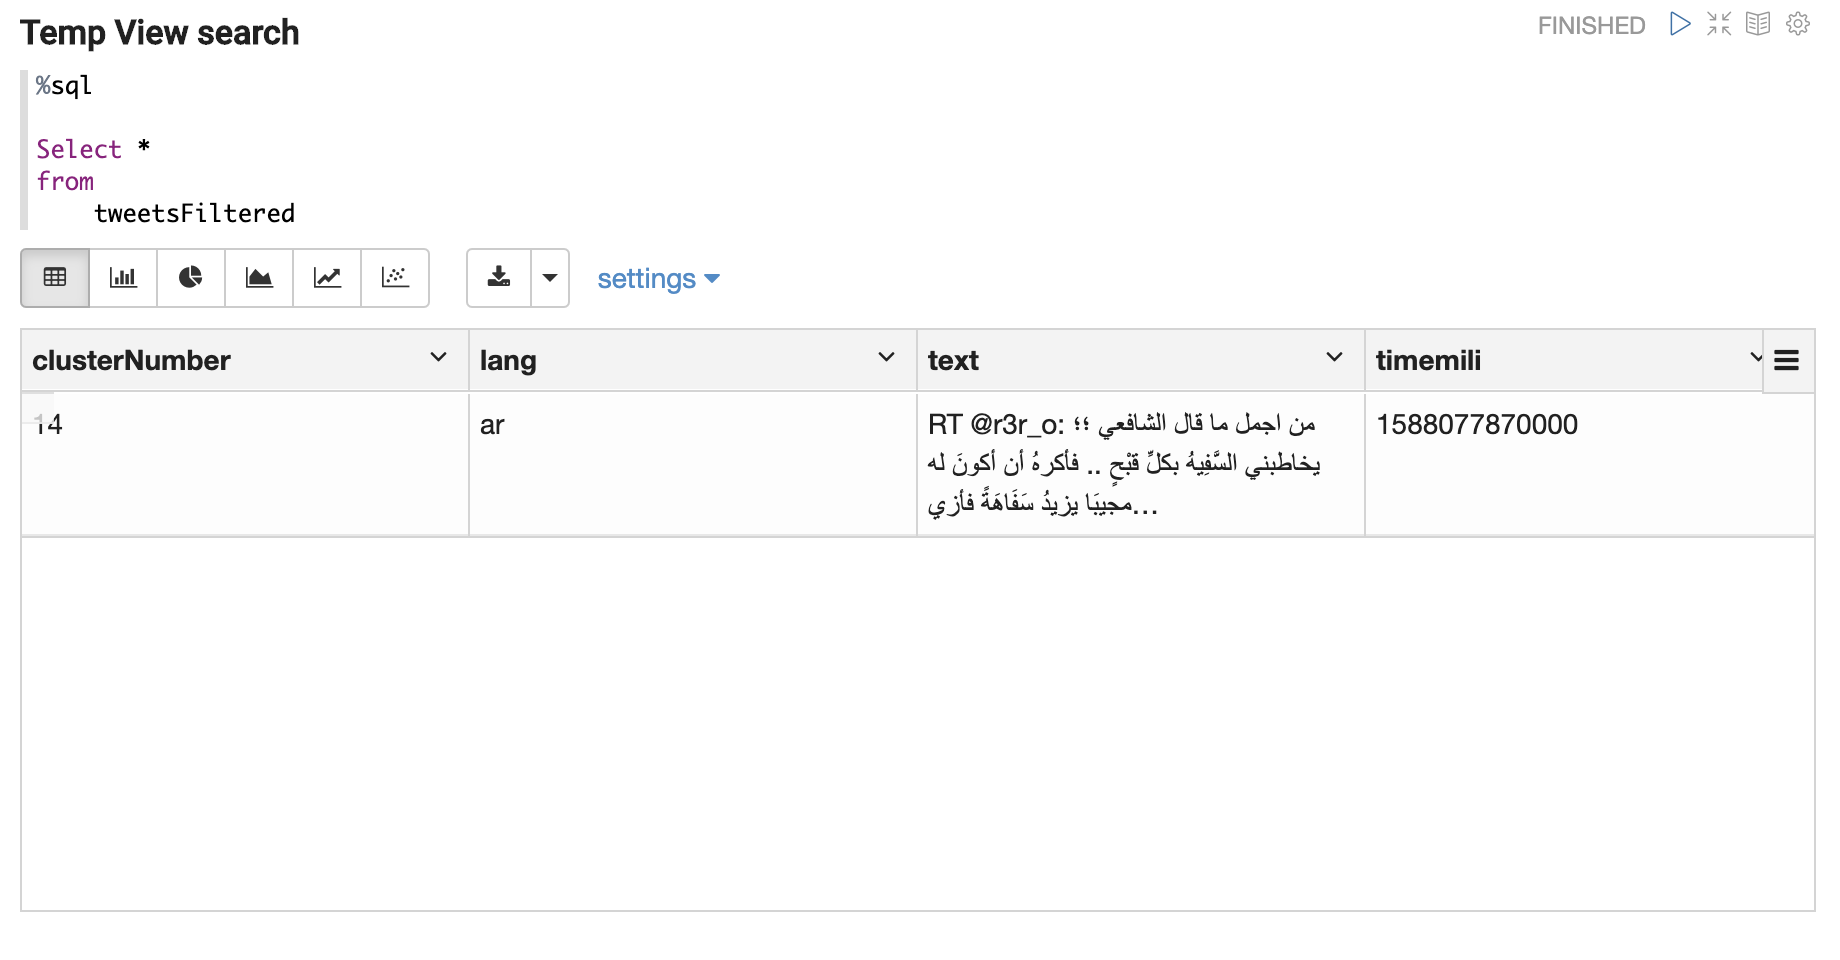

In [15]:
Image('./capture/stream_09.png')

-----

In [ ]:
%sql

select
*
from
tweetsFiltereddf

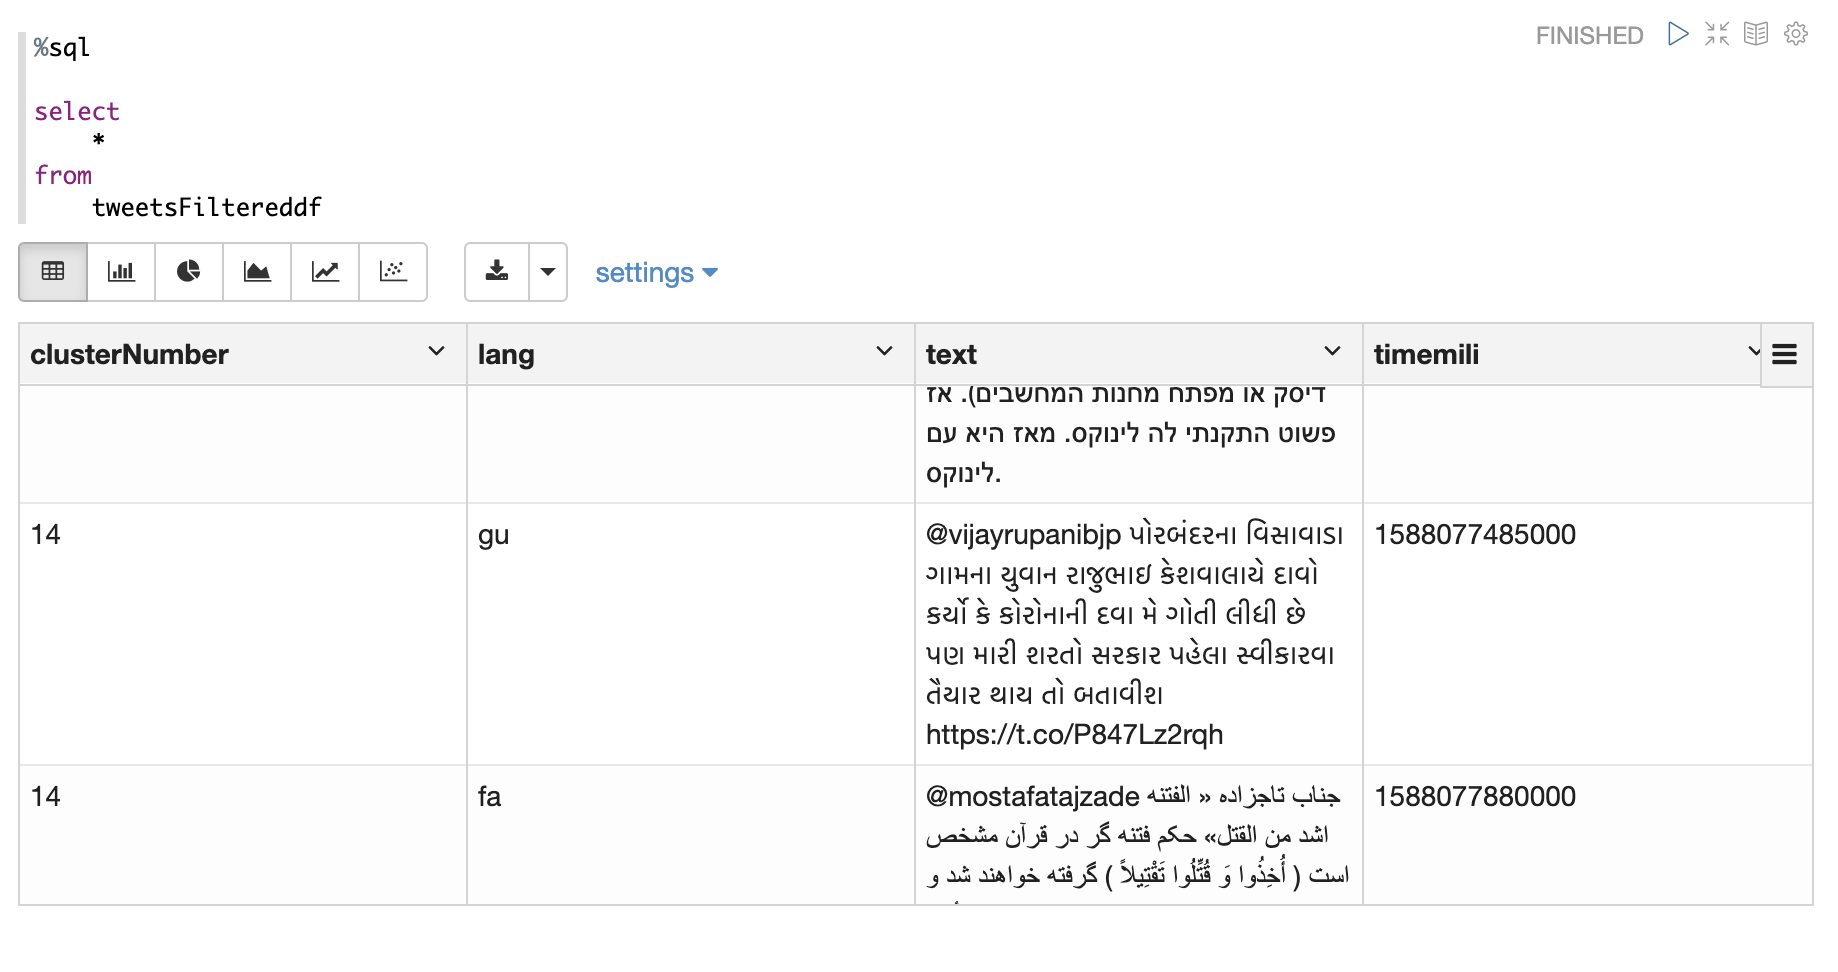

In [16]:
Image('./capture/stream_10.png')

----

In [ ]:
%sql

select
*
from
tweetsFiltereddf
where
true
and lang != 'ar'

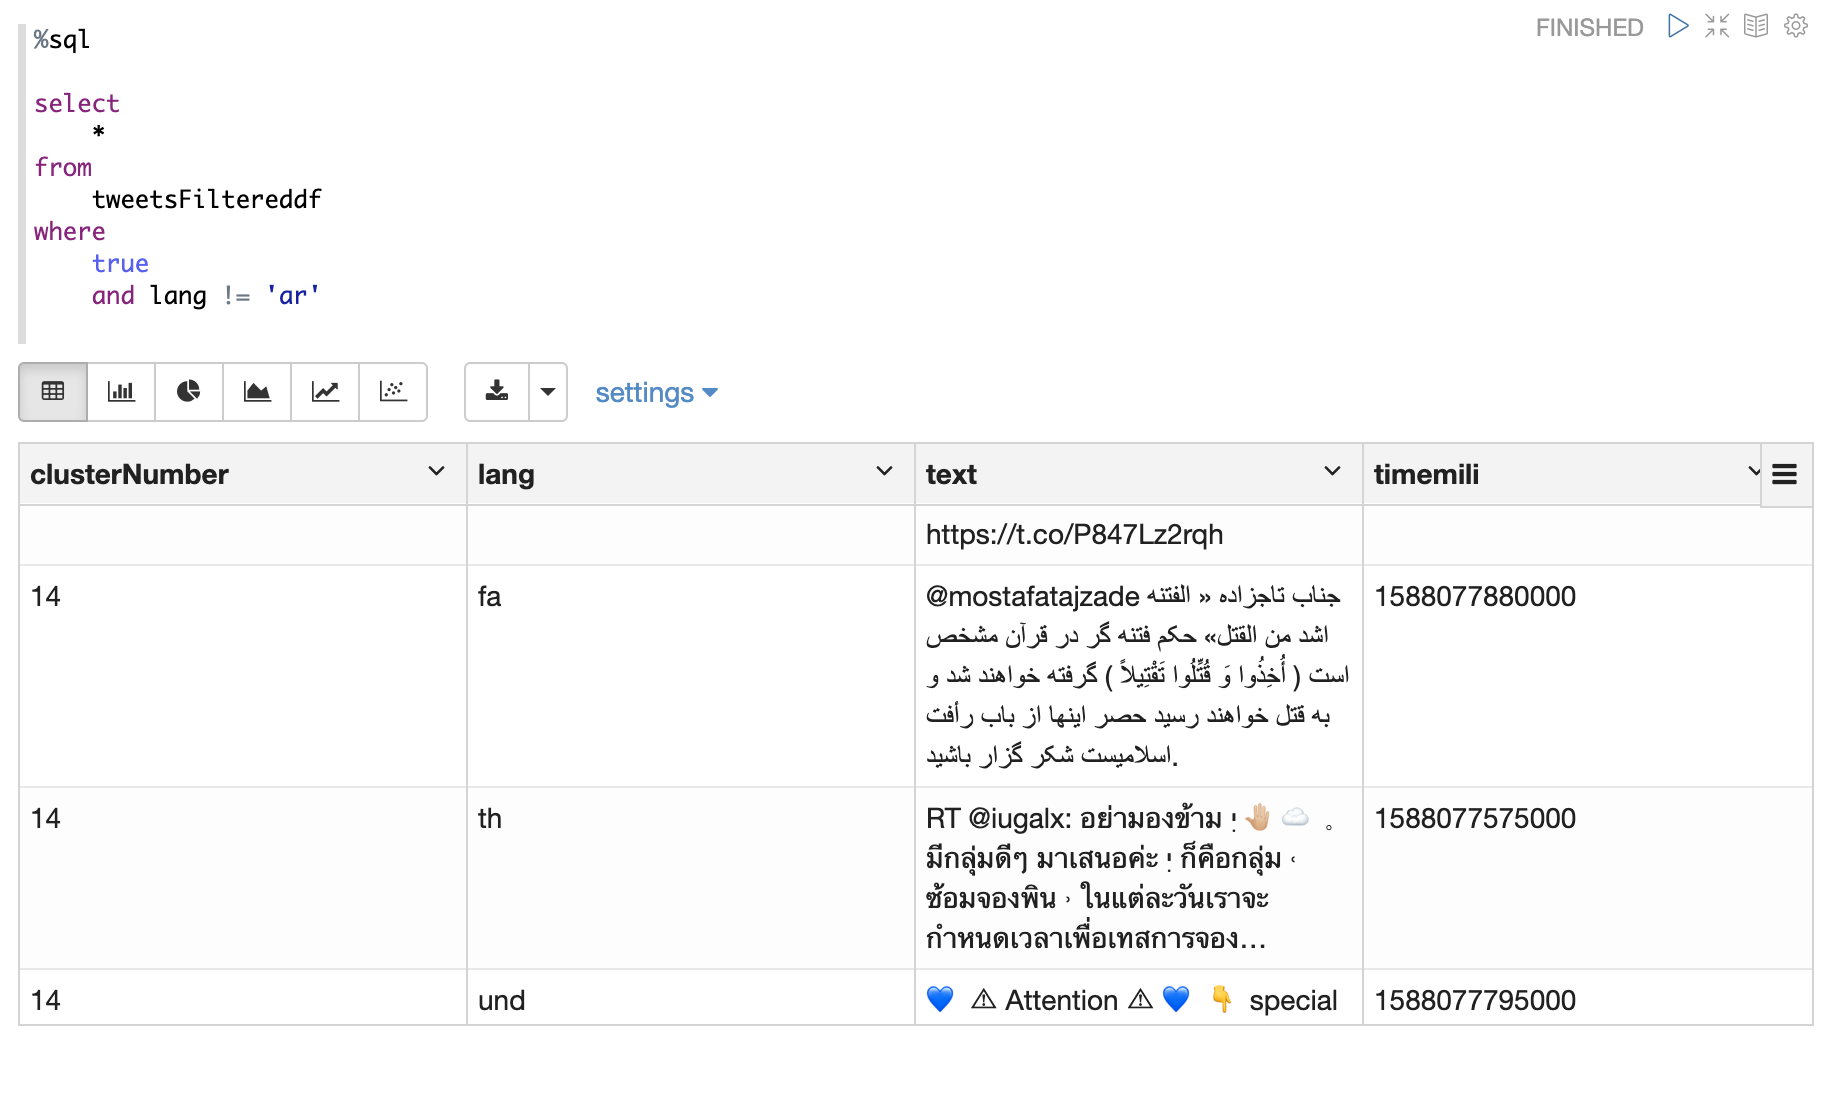

In [17]:
Image('./capture/stream_11.png')

------


### create note

 - Word2Vec
 - Interpreter : spark3
 
----

    sc.version
    sc.master
    sc.sparkUser

-----
### spark3 interpreter setting change

 - spark.jars.packages // org.apache.bahir:spark-streaming-twitter_2.11:2.3.4,com.twitter.penguin:korean-text:4.4

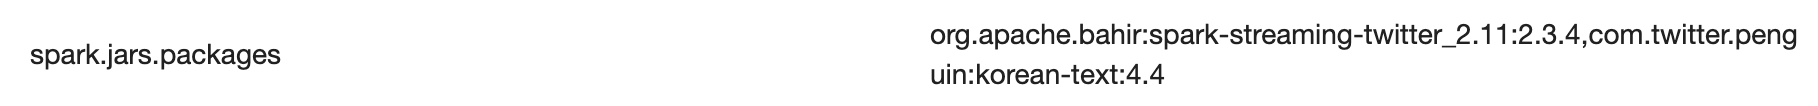

In [19]:
Image('./capture/penguin_01.png')

-----

#### twitter 형태소 분석기 test



In [ ]:
import com.twitter.penguin.korean.TwitterKoreanProcessor
import com.twitter.penguin.korean.phrase_extractor.KoreanPhraseExtractor.KoreanPhrase
import com.twitter.penguin.korean.tokenizer.KoreanTokenizer.KoreanToken

val text = "한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ #한국어"
    println(">>>> 원문 : " + text)
    //--한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ  # 한국어

    //--Normalize(정규화)....
    val normalized: CharSequence = TwitterKoreanProcessor.normalize(text)
    println(">>>> Normalize(정규화) : " + normalized)
    //--한국어를 처리하는 예시입니다ㅋㅋ  # 한국어

    //--Tokenize(토큰화)....
    val tokens: Seq[KoreanToken] = TwitterKoreanProcessor.tokenize(normalized)
    println(">>>> Tokenize(토큰화) : " + tokens)
    //--List(한국어(Noun: 0, 3), 를(Josa: 3, 1),  (Space: 4, 1), 처리(Noun: 5, 2), 하는(Verb: 7, 2),  (Space: 9, 1), 예시(Noun: 10, 2), 입니(Adjective: 12, 2), 다(Eomi: 14, 1), ㅋㅋ(KoreanParticle: 15, 2),  (Space: 17, 1),  # 한국어(Hashtag: 18, 4))

    // --Stemming(어근화)....
    val stemmed: Seq[KoreanToken]=TwitterKoreanProcessor.stem(tokens)
    println(">>>> Stemming(어근화) : " + stemmed)
    // --List(한국어(Noun: 0, 3), 를(Josa: 3, 1),  (Space: 4, 1), 처리(Noun: 5, 2), 하다(Verb: 7, 2),  (Space: 9, 1), 예시(Noun: 10, 2), 이다(Adjective: 12, 3), ㅋㅋ(KoreanParticle: 15, 2),  (Space: 17, 1),  # 한국어(Hashtag: 18, 4))

    // --Phrase extraction(어구 추출)....
    val phrases: Seq[KoreanPhrase]=TwitterKoreanProcessor.extractPhrases(tokens, filterSpam=true, enableHashtags=true)
    println(">>>> Phrase extraction(어구 추출)(from Tokens) : " + phrases)
    // --List(한국어(Noun: 0, 3), 처리(Noun: 5, 2), 처리하는 예시(Noun: 5, 7), 예시(Noun: 10, 2),  # 한국어(Hashtag: 18, 4))

    phrases.foreach {x= > println(x.text)}


    // --Phrase extraction(어구 추출)  # 2....
    val phrases2: Seq[KoreanPhrase]=TwitterKoreanProcessor.extractPhrases(stemmed, filterSpam=true, enableHashtags=true)
    println(">>>> Phrase extraction(어구 추출)(from Stemmed) #2 : " + phrases2)
    // --List(한국어(Noun: 0, 3), 처리(Noun: 5, 2), 예시(Noun: 10, 2),  # 한국어(Hashtag: 18, 4))

    phrases2.foreach {x= > println(x.text)}

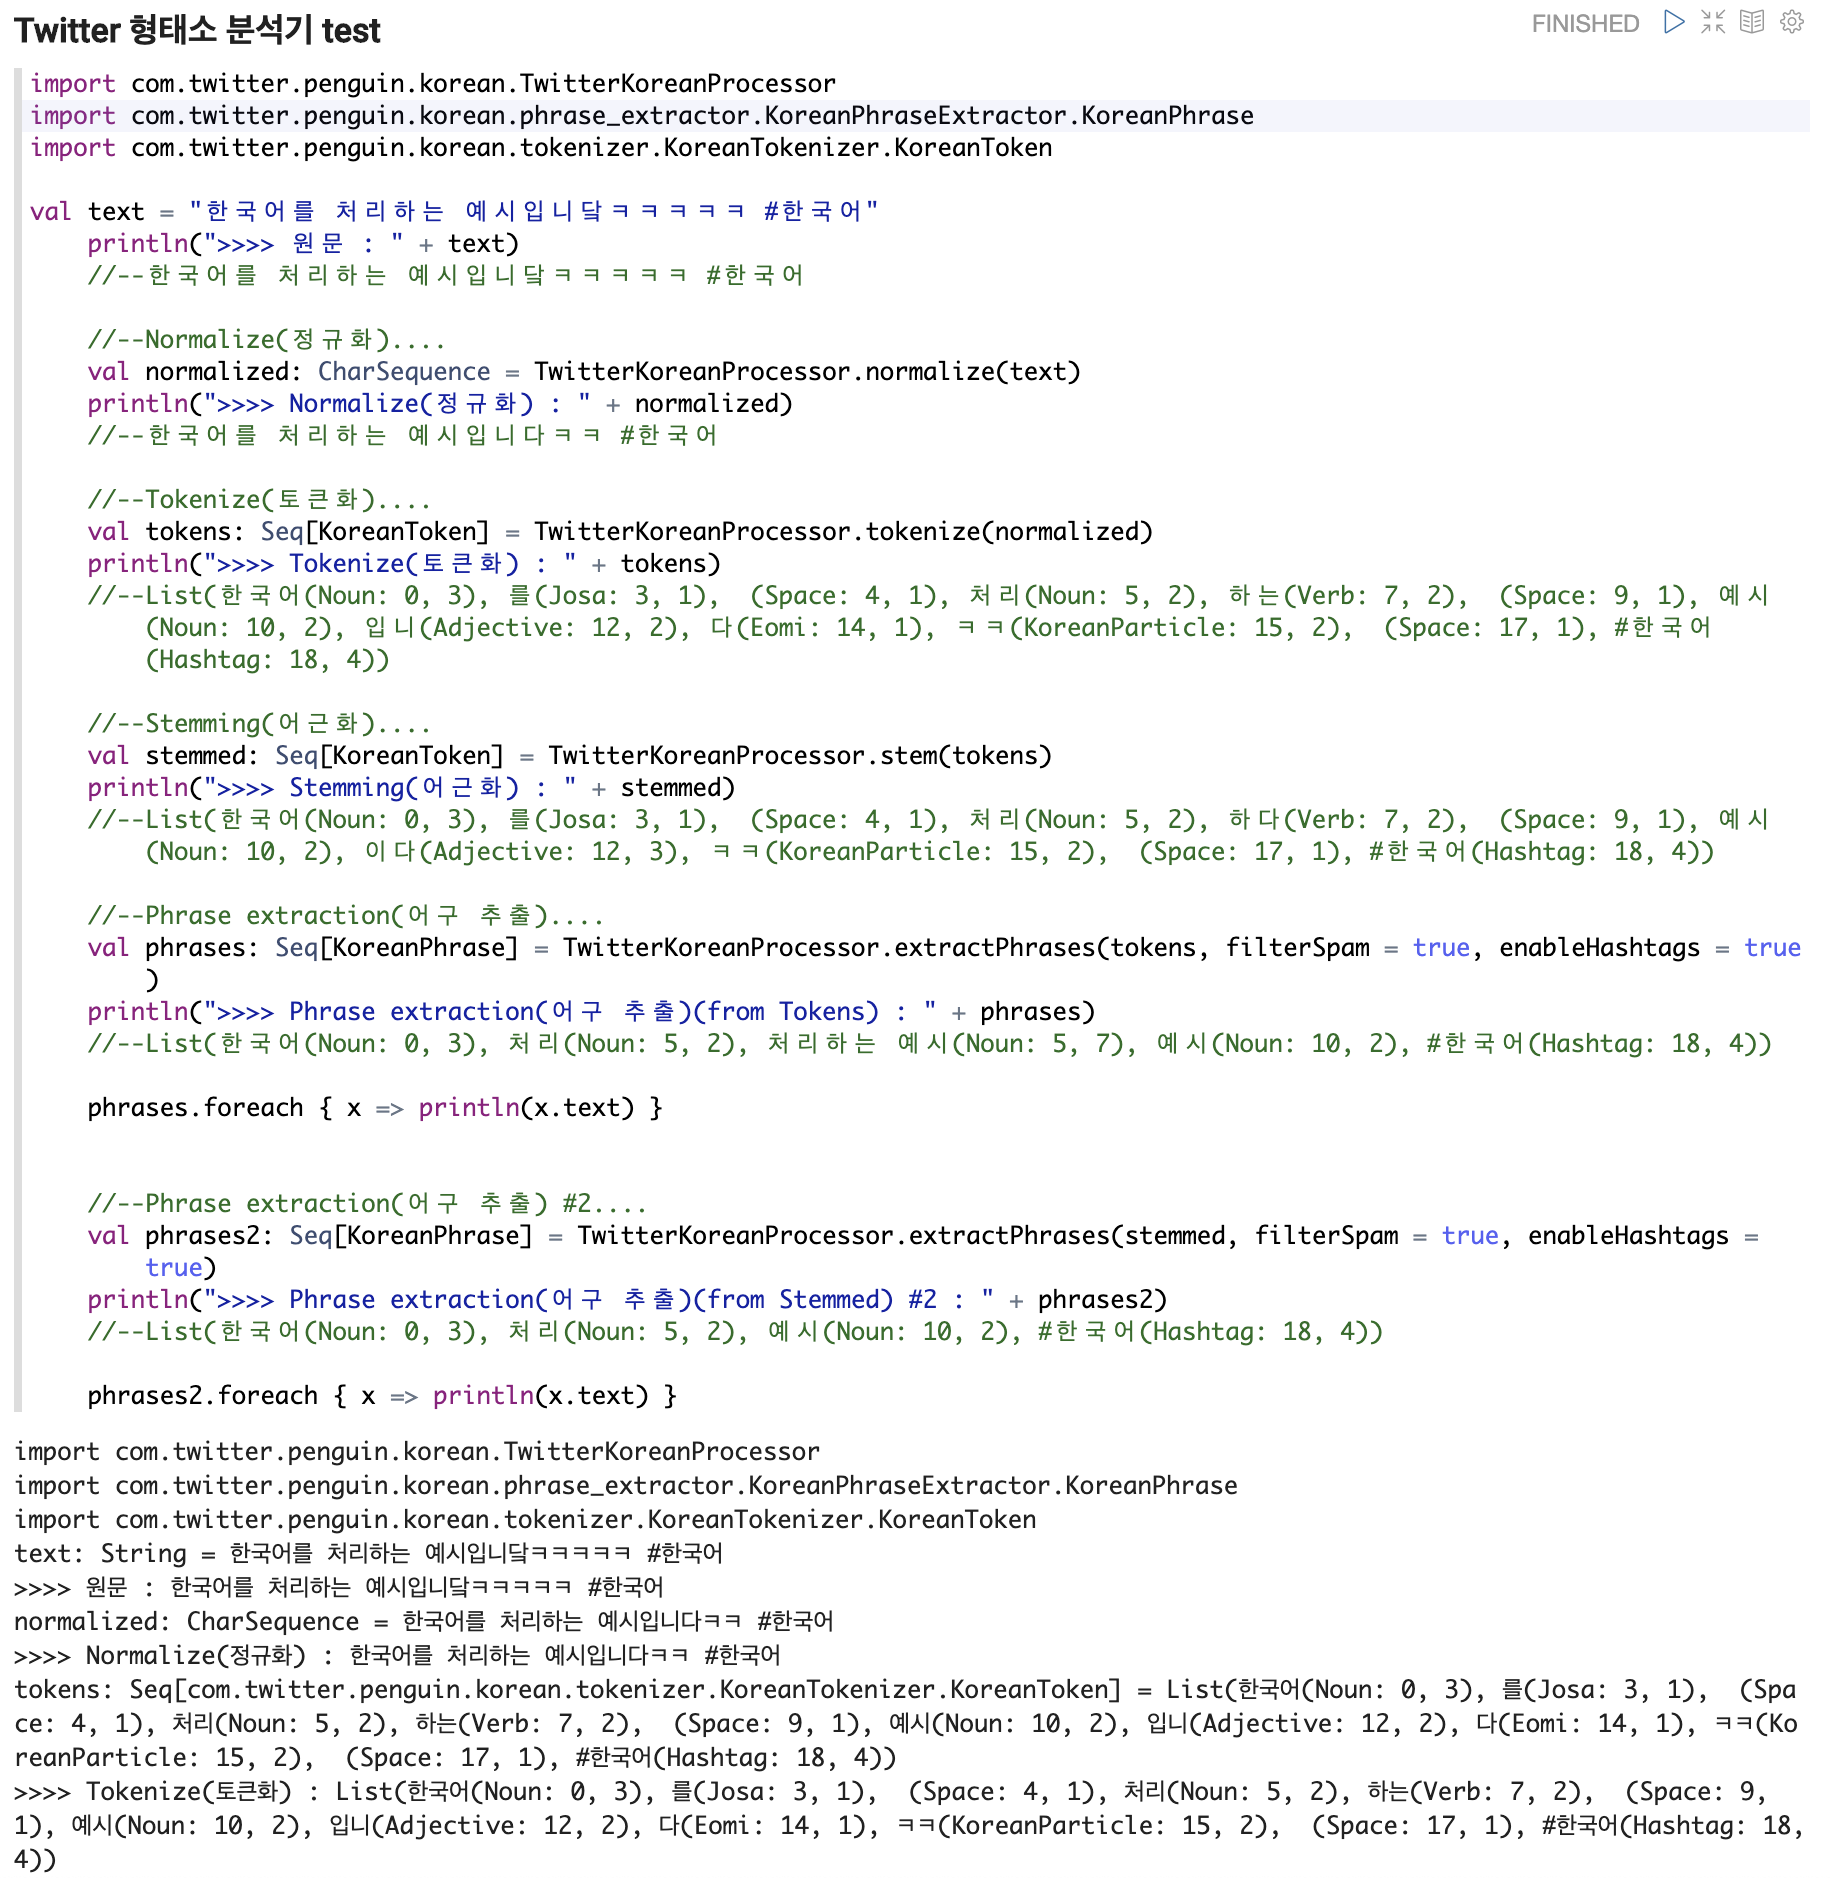

In [20]:
Image('./capture/penguin_02.png')